In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import cv2
import scipy.misc
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


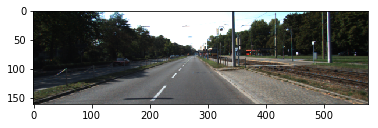

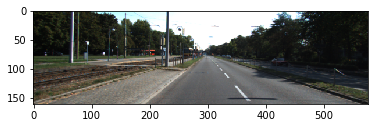

In [2]:
# flipping image
image_shape = (160, 576)
image_file = "./data/data_road/testing/image_2/um_000001.png"
image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
flip_img = np.flip(image, axis=1)

plt.imshow(image)
plt.show()
plt.imshow(flip_img)
plt.show()

In [3]:
image_shape = (160, 576)

def process_image(image):
    image = scipy.misc.imresize(image, image_shape)
    session = tf.get_default_session()
    
    im_softmax = sess.run(
        [tf.nn.softmax(logits)],
        {keep_prob: 1.0, image_input: [image]})
    im_softmax_road = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation_road = (im_softmax_road > 0.5).reshape(image_shape[0], image_shape[1], 1)

    im_softmax_other_road = im_softmax[0][:, 2].reshape(image_shape[0], image_shape[1])
    segmentation_other_road = (im_softmax_other_road > 0.5).reshape(image_shape[0], image_shape[1], 1)

    # green road
    mask_road = np.dot(segmentation_road, np.array([[0, 255, 0, 127]]))
    mask_road = scipy.misc.toimage(mask_road, mode="RGBA")

    # blue other_road
    mask_other_road = np.dot(segmentation_other_road, np.array([[0, 0, 255, 127]]))
    mask_other_road = scipy.misc.toimage(mask_other_road, mode="RGBA")

    street_im = scipy.misc.toimage(image)
    street_im.paste(mask_road, box=None, mask=mask_road)
    street_im.paste(mask_other_road, box=None, mask=mask_other_road)

    return np.array(street_im)

In [5]:
video_output = './video/output.mp4'
clip = VideoFileClip('./video/project_video.mp4')

with tf.Session() as sess:
    
    saver = tf.train.import_meta_graph('my_model8.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    graph = tf.get_default_graph()
    logits = graph.get_tensor_by_name("logits:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    image_input = graph.get_tensor_by_name("image_input:0")
   
    project_clip = clip.fl_image(process_image)
    %time project_clip.write_videofile(video_output, audio=False)

INFO:tensorflow:Restoring parameters from ./my_model8.ckpt
[MoviePy] >>>> Building video ./video/output.mp4
[MoviePy] Writing video ./video/output.mp4


100%|█████████▉| 1260/1261 [14:04<00:00,  1.47it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video/output.mp4 

CPU times: user 9min 18s, sys: 5min 4s, total: 14min 23s
Wall time: 14min 4s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))